In [14]:
from typing import List
from typing import Tuple
import os
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import pandas
from sklearn import model_selection
from sklearn import neighbors
from sklearn import pipeline
from sklearn import preprocessing
from quantile_forest import RandomForestQuantileRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

In [15]:
path = "../data"

SALES_PATH = os.path.join(path, "kc_house_data.csv")  # path to CSV with home sale data
DEMOGRAPHICS_PATH = os.path.join(path, "kc_house_data.csv")  # path to CSV with demographics
# List of columns (subset) that will be taken from home sale data
SALES_COLUMN_SELECTION = [
    'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
    'sqft_above', 'sqft_basement', 'zipcode'
]
OUTPUT_DIR = os.path.join(path, "model")  # Directory where output artifacts will be saved

In [16]:
def load_data(
    sales_path: str, demographics_path: str, sales_column_selection: List[str]
) -> Tuple[pandas.DataFrame, pandas.Series]:
    """Load the target and feature data by merging sales and demographics.

    Args:
        sales_path: path to CSV file with home sale data
        demographics_path: path to CSV file with home sale data
        sales_column_selection: list of columns from sales data to be used as
            features

    Returns:
        Tuple containg with two elements: a DataFrame and a Series of the same
        length.  The DataFrame contains features for machine learning, the
        series contains the target variable (home sale price).

    """
    data = pandas.read_csv(sales_path,
                           usecols=sales_column_selection,
                           dtype={'zipcode': str})
    demographics = pandas.read_csv(os.path.join(path, "zipcode_demographics.csv"),
                                   dtype={'zipcode': str})

    merged_data = data.merge(demographics, how="left",
                             on="zipcode").drop(columns="zipcode")
    # Remove the target variable from the dataframe, features will remain
    y = merged_data.pop('price')
    x = merged_data

    return x, y

In [17]:
x, y = load_data(SALES_PATH, DEMOGRAPHICS_PATH, SALES_COLUMN_SELECTION)
x_train, _x_test, y_train, _y_test = model_selection.train_test_split(x, y, random_state=42)

### Training the Baseline Model

In [18]:
model = pipeline.make_pipeline(preprocessing.RobustScaler(),
                               neighbors.KNeighborsRegressor()).fit(x_train, y_train)



### Evaluating the Baseline Model


In [19]:
y_train_pred = model.predict(x_train)
_y_pred = model.predict(_x_test)

print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE :", mean_squared_error(_y_test, _y_pred))
print("\n")

print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE :", mean_absolute_error(_y_test, _y_pred))
print("\n")

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE :", np.sqrt(mean_squared_error(_y_test, _y_pred)))
print("\n")

print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R² :", r2_score(_y_test, _y_pred))
print("\n")

print("Train Explained Variance Score:", explained_variance_score(y_train, y_train_pred))
print("Test Explained Variance Score:", explained_variance_score(_y_test, _y_pred))

Train MSE: 20582803584.894634
Test MSE : 40666502344.8377


Train MAE: 76233.42808316369
Test MAE : 102044.0115099926


Train RMSE: 143467.08188603626
Test RMSE : 201659.3720729034


Train R²: 0.8414398033722691
Test R² : 0.7281426018361323


Train Explained Variance Score: 0.8422336332595497
Test Explained Variance Score: 0.7307120304380628


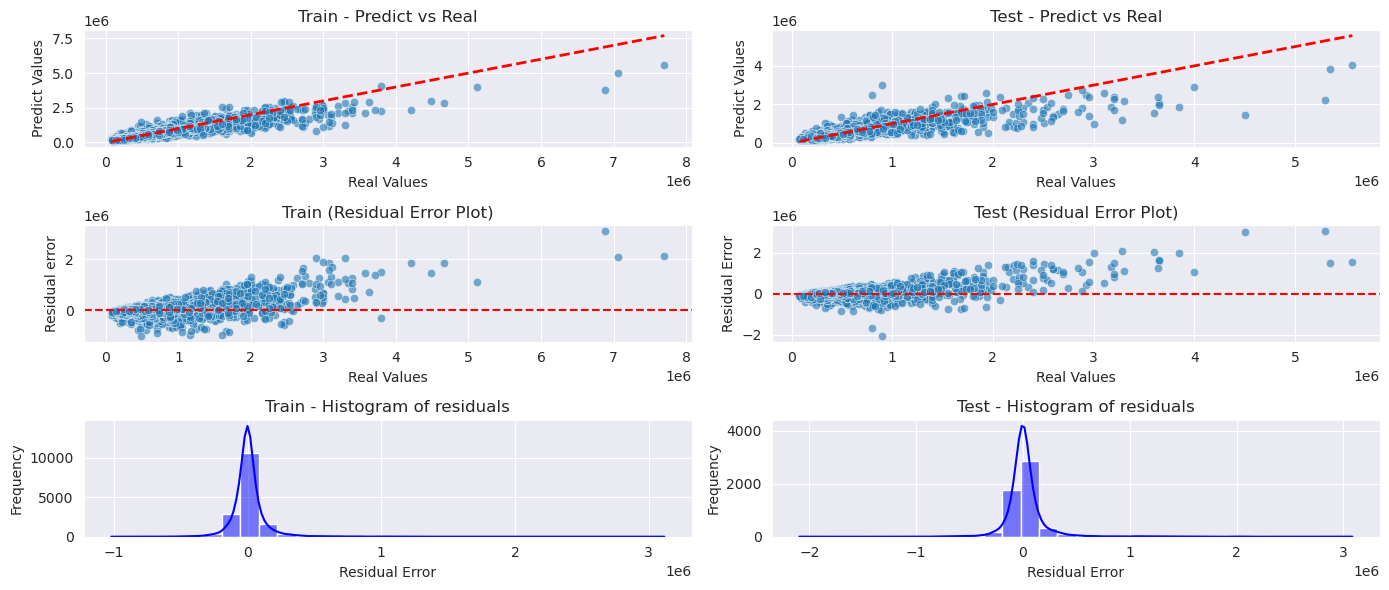

In [20]:
def plot_residuals(y_train, y_train_pred, y_test, _y_pred, train_residuals, test_residuals):

  fig, axes = plt.subplots(3, 2, figsize=(14, 6))

  sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.6, ax=axes[0][0])
  axes[0][0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
  axes[0][0].set_xlabel("Real Values")
  axes[0][0].set_ylabel("Predict Values")
  axes[0][0].set_title("Train - Predict vs Real")
  axes[0][0].grid(True)

  sns.scatterplot(x=_y_test, y=_y_pred, alpha=0.6, ax=axes[0][1])
  axes[0][1].plot([_y_test.min(), _y_test.max()], [_y_test.min(), _y_test.max()], 'r--', lw=2)
  axes[0][1].set_xlabel("Real Values")
  axes[0][1].set_ylabel("Predict Values")
  axes[0][1].set_title("Test - Predict vs Real")
  axes[0][1].grid(True)

  sns.scatterplot(x=y_train, y=train_residuals, alpha=0.6, ax=axes[1][0])
  axes[1][0].axhline(0, color='r', linestyle='--')
  axes[1][0].set_xlabel("Real Values")
  axes[1][0].set_ylabel("Residual error")
  axes[1][0].set_title("Train (Residual Error Plot)")
  axes[1][0].grid(True)

  sns.scatterplot(x=y_test, y=test_residuals, alpha=0.6, ax=axes[1][1])
  axes[1][1].axhline(0, color='r', linestyle='--')
  axes[1][1].set_xlabel("Real Values")
  axes[1][1].set_ylabel("Residual Error")
  axes[1][1].set_title("Test (Residual Error Plot)")
  axes[1][1].grid(True)

  sns.histplot(train_residuals, kde=True, ax=axes[2][0], color='blue', bins=30)
  axes[2][0].set_xlabel("Residual Error")
  axes[2][0].set_ylabel("Frequency")
  axes[2][0].set_title("Train - Histogram of residuals")
  axes[2][0].grid(True)

  sns.histplot(test_residuals, kde=True, ax=axes[2][1], color='blue', bins=30)
  axes[2][1].set_xlabel("Residual Error")
  axes[2][1].set_ylabel("Frequency")
  axes[2][1].set_title("Test - Histogram of residuals")
  axes[2][1].grid(True)

  plt.tight_layout()
  plt.show()


train_residuals = y_train - y_train_pred
test_residuals = _y_test - _y_pred

plot_residuals(y_train, y_train_pred, _y_test, _y_pred, train_residuals, test_residuals)